In [ ]:
import os
import sys
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as pimg
import seaborn as sns
import math
import tqdm
from tqdm.notebook import tqdm
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalMaxPooling2D
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler

In [ ]:
print(sys.version)
print('tensorflow -> ', tf.__version__)
print(tf.test.gpu_device_name())

3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]
tensorflow ->  2.1.0



In [ ]:
np.random.seed(12)
tf.random.set_seed(12)

In [ ]:
main_df = pd.read_csv('Train.csv')
sub_df = pd.read_csv('SampleSubmission.csv')

image_name = pd.concat([main_df['UID'], sub_df['UID']], axis=0, ignore_index=True)

data_dir = 'Images/'

print('main_df shape: ', main_df.shape)
print('sub_df shape: ', sub_df.shape)
print('total: ', main_df.shape[0] + sub_df.shape[0])

main_df shape:  (10695, 3)
sub_df shape:  (3558, 2)
total:  14253


In [ ]:
main_df.head()

UID  growth_stage  label_quality
0  nwuCTQKz             4              2
1  NVGUOzWu             1              1
2  1IYVvHwA             1              1
3  8OEdWwmU             1              1
4  oc5iO04j             1              1

In [ ]:
print('shape: ', main_df.shape)
print('=' * 40)
print(main_df['growth_stage'].value_counts())
print('=' * 40)
print(main_df['label_quality'].value_counts())

shape:  (10695, 3)
1    3057
7    2335
4    1712
2    1389
5    1092
3     689
6     421
Name: growth_stage, dtype: int64
1    7839
2    2856
Name: label_quality, dtype: int64


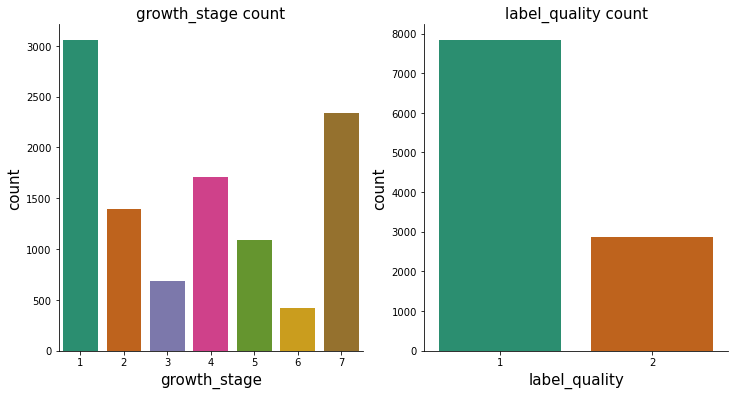

In [ ]:
num_features = ['growth_stage', 'label_quality']

sns.set_palette('Dark2')
fig, ax = plt.subplots(1, len(num_features), figsize=(12, 6))

for i, col in enumerate(num_features):
    sns.countplot(x=col, data=main_df, ax=ax[i])
    ax[i].set_xlabel(col, fontsize=15)
    ax[i].set_ylabel('count', fontsize=15)
    ax[i].set_title(col + ' count', fontsize=15)
    sns.despine()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


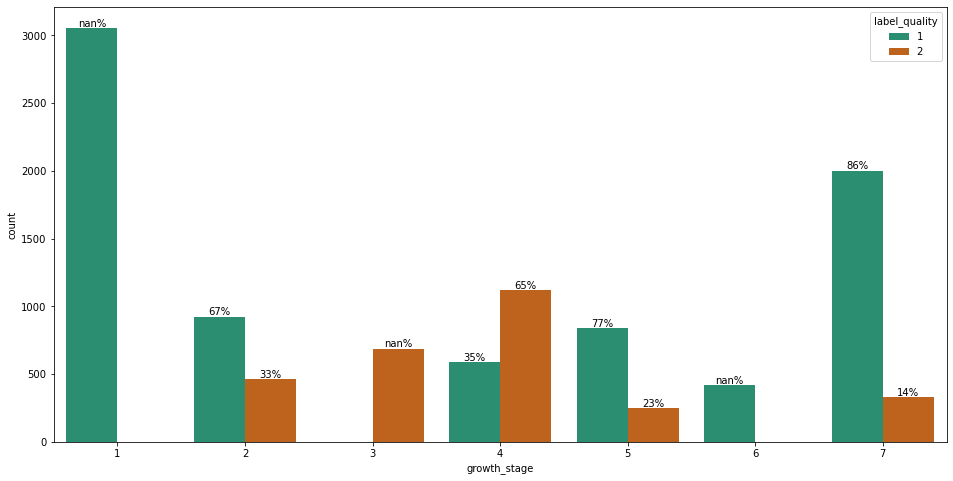

In [ ]:
plt.figure(figsize=(16,8))
ax = sns.countplot(x='growth_stage', data=main_df ,hue='label_quality')
bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r

    ax.text(left.get_x() + left.get_width()/2., height_l + 10, '{0:.0%}'.format(height_l/total), ha='center')
    ax.text(right.get_x() + right.get_width()/2., height_r + 10, '{0:.0%}'.format(height_r/total), ha='center')

In [ ]:
lq_data = main_df.loc[main_df.label_quality == 1]
hq_data = main_df.loc[main_df.label_quality == 2]

st1_lq = lq_data.loc[lq_data.growth_stage == 1]
st2_lq = lq_data.loc[lq_data.growth_stage == 2]
st4_lq = lq_data.loc[lq_data.growth_stage == 4]
st5_lq = lq_data.loc[lq_data.growth_stage == 5]
st6_lq = lq_data.loc[lq_data.growth_stage == 6]
st7_lq = lq_data.loc[lq_data.growth_stage == 7]

st2_hq = hq_data.loc[hq_data.growth_stage == 2]
st3_hq = hq_data.loc[hq_data.growth_stage == 3]
st4_hq = hq_data.loc[hq_data.growth_stage == 4]
st5_hq = hq_data.loc[hq_data.growth_stage == 5]
st7_hq = hq_data.loc[hq_data.growth_stage == 7]

In [ ]:
"""import shutil


for fname in st7_hq.UID:
    img = fname + '.jpeg'
    org_path = 'Images/' + img
    to_path = 'data/HQ/st7_hq/' + img
    shutil.copy(org_path, to_path)
    """

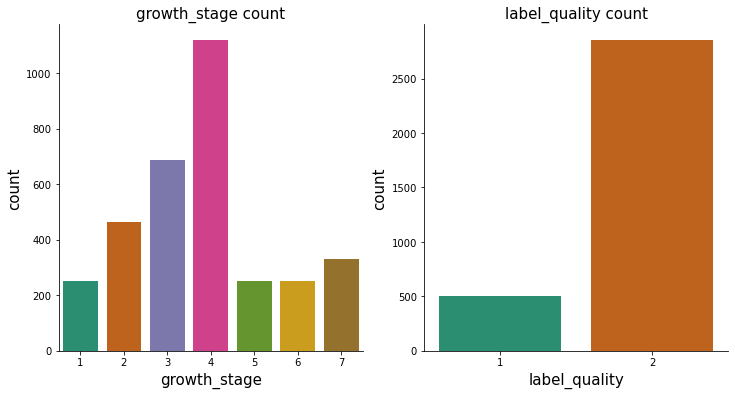

In [ ]:
num_features = ['growth_stage', 'label_quality']

sns.set_palette('Dark2')
fig, ax = plt.subplots(1, len(num_features), figsize=(12, 6))

for i, col in enumerate(num_features):
    sns.countplot(x=col, data=hq_df, ax=ax[i])
    ax[i].set_xlabel(col, fontsize=15)
    ax[i].set_ylabel('count', fontsize=15)
    ax[i].set_title(col + ' count', fontsize=15)
    sns.despine()

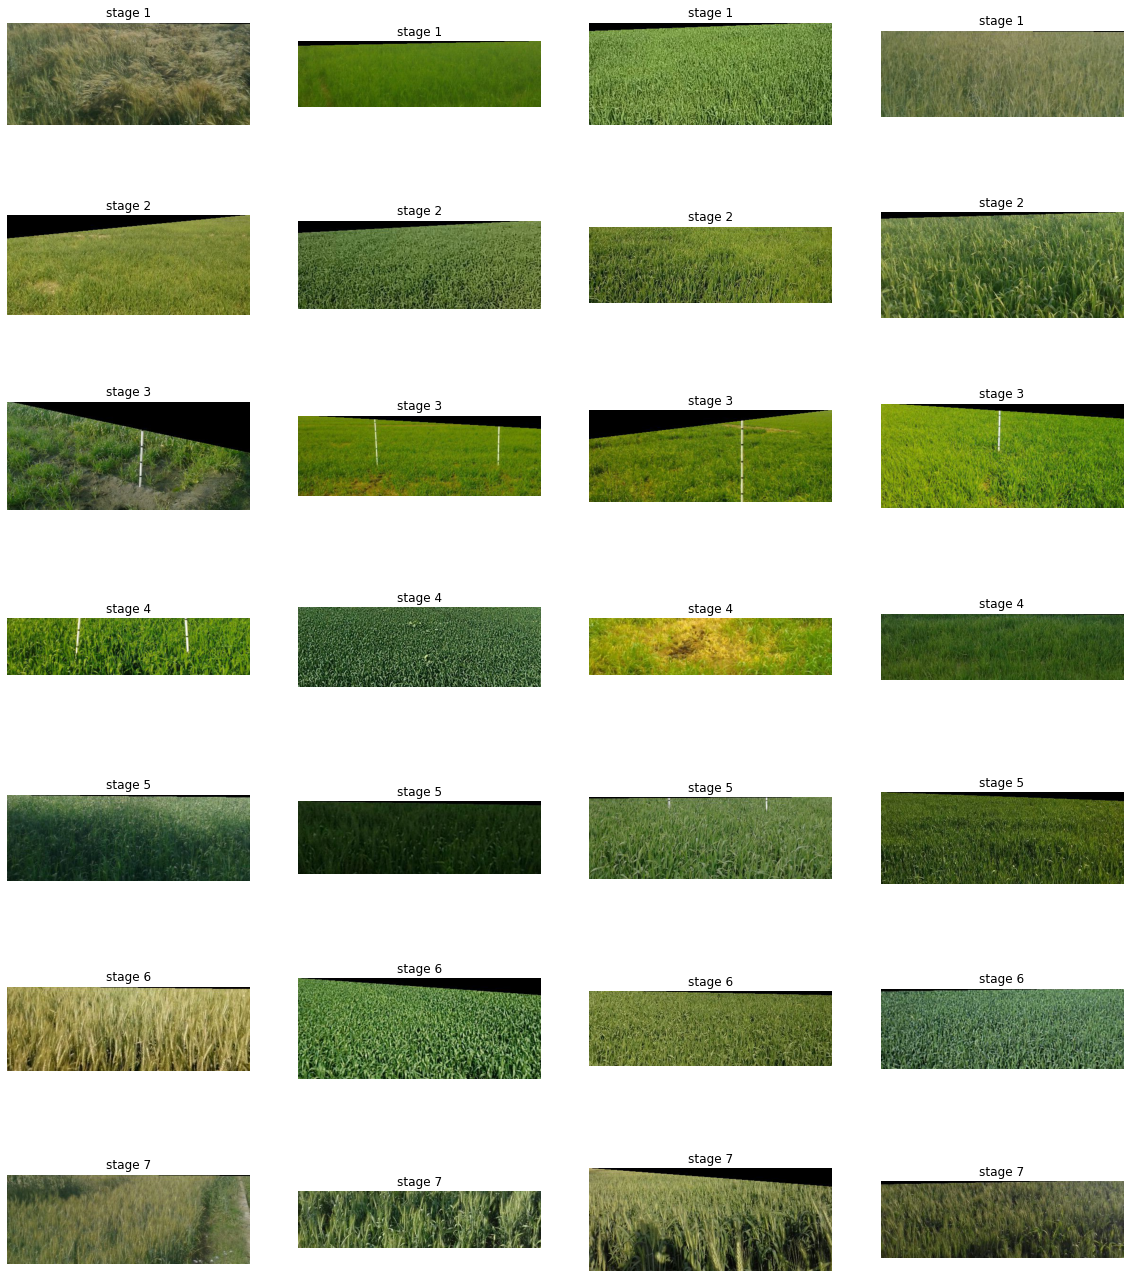

In [ ]:
fig, ax = plt.subplots(7, 4, figsize = (20,24))

for i in range(7):
    stage_num = i + 1
    for j, idx in enumerate(main_df[main_df['growth_stage'] == stage_num]['UID'][-4:]):
        fname = idx + '.jpeg'
        path = os.path.join(data_dir, fname)
        img = load_img(path)
        ax[i, j].axis('off')
        ax[i, j].set_title('stage ' + str(stage_num))
        ax[i, j].imshow(img)

In [ ]:
fig, ax = plt.subplots(6, 4, figsize = (20,24))

for i in range(7):
    stage_num = i + 1
    if stage_num < 3:
        for j, idx in enumerate(lq_data[lq_data['growth_stage'] == stage_num]['UID'][-4:]):
            fname = idx + '.jpeg'
            path = os.path.join(data_dir, fname)
            img = load_img(path)
            ax[i, j].axis('off')
            ax[i, j].set_title('LQ-stage ' + str(stage_num))
            ax[i, j].imshow(img)
    elif stage_num > 3:
        i -= 1
        for k, idx in enumerate(lq_data[lq_data['growth_stage'] == stage_num]['UID'][-4:]):
            fname = idx + '.jpeg'
            path = os.path.join(data_dir, fname)
            img = load_img(path)
            ax[i, k].axis('off')
            ax[i, k].set_title('LQ-stage ' + str(stage_num))
            ax[i, k].imshow(img)
    else:
        pass

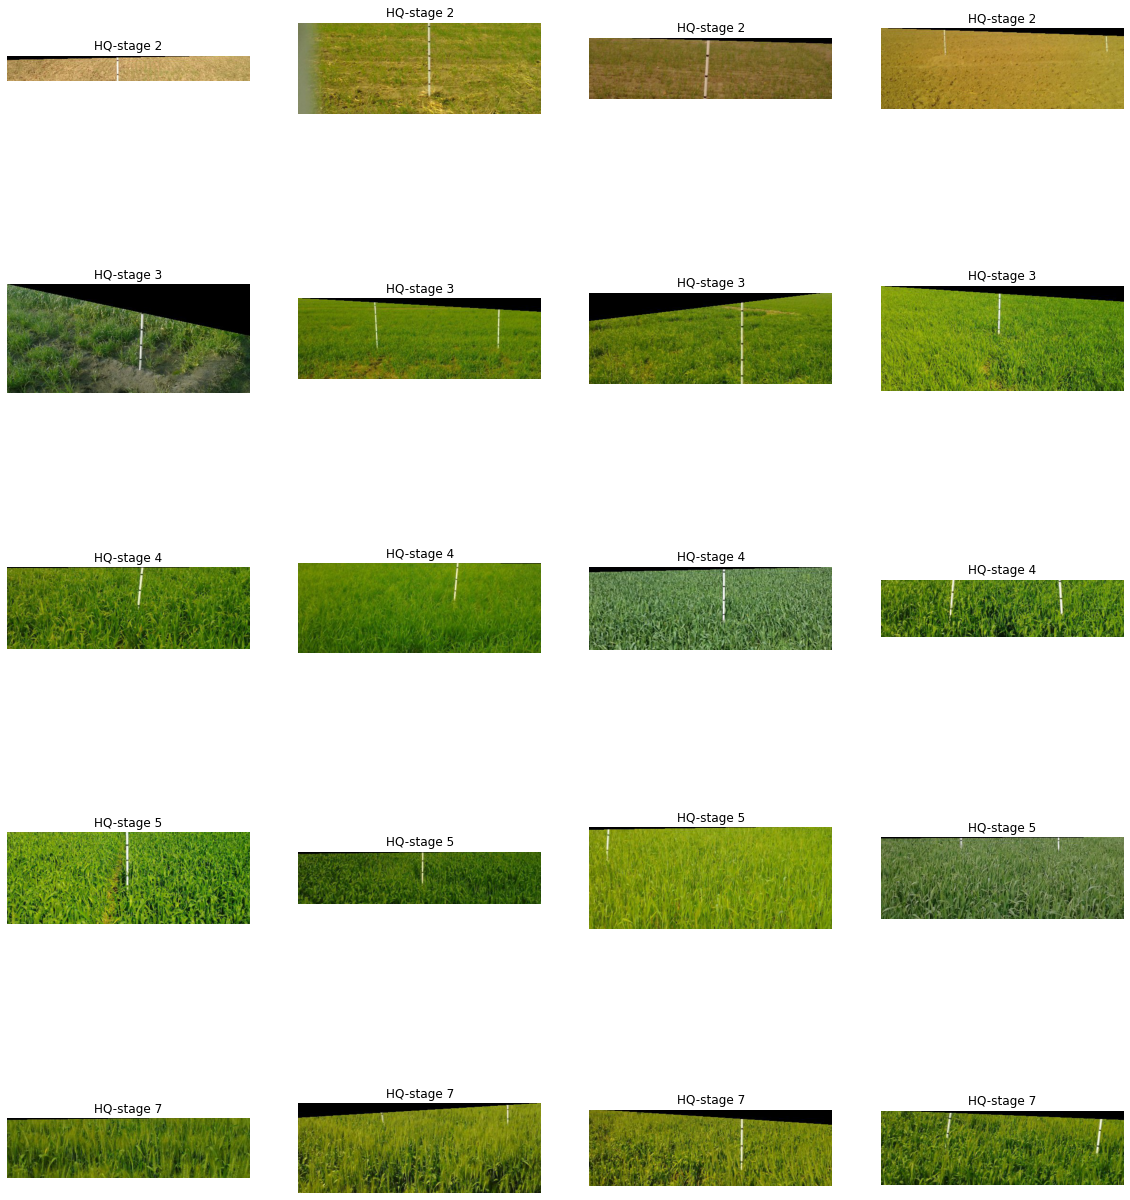

In [ ]:
fig, ax = plt.subplots(5, 4, figsize = (20,24))

for i in range(7):
    stage_num = i + 1
    i -= 1
    if (1 < stage_num < 6):
        for j, idx in enumerate(hq_data[hq_data['growth_stage'] == stage_num]['UID'][-4:]):
            fname = idx + '.jpeg'
            path = os.path.join(data_dir, fname)
            img = load_img(path)
            ax[i, j].axis('off')
            ax[i, j].set_title('HQ-stage ' + str(stage_num))
            ax[i, j].imshow(img)
    elif stage_num == 7:
        i -= 1
        for k, idx in enumerate(hq_data[hq_data['growth_stage'] == stage_num]['UID'][-4:]):
            fname = idx + '.jpeg'
            path = os.path.join(data_dir, fname)
            img = load_img(path)
            ax[i, k].axis('off')
            ax[i, k].set_title('HQ-stage ' + str(stage_num))
            ax[i, k].imshow(img)
    else:
        pass

In [ ]:
"""size_cols = ['UID', 'width', 'height']
image_size_df = pd.DataFrame(index=[], columns=size_cols)
num = main_df.shape[0]

for i, idx in tqdm(enumerate(main_df['UID'])):
    fname = idx + '.jpeg'
    path = os.path.join(save_dir, fname)
    img = cv2.imread(path)
    h, w, _ = img.shape
    record = pd.Series([idx, w, h], index=image_size_df.columns)
    image_size_df = image_size_df.append(record, ignore_index=True)

image_size_df.head()
image_size_df.to_csv('aug_train_image_size.csv', index=False)
"""

In [ ]:
"""size_cols = ['UID', 'width', 'height']
image_size_df = pd.DataFrame(index=[], columns=size_cols)
num = sub_df.shape[0]

for i, idx in tqdm(enumerate(sub_df['UID'])):
    fname = idx + '.jpeg'
    path = os.path.join(save_dir, fname)
    img = cv2.imread(path)
    h, w, _ = img.shape
    record = pd.Series([idx, w, h], index=image_size_df.columns)
    image_size_df = image_size_df.append(record, ignore_index=True)

image_size_df.head()
image_size_df.to_csv('aug_test_image_size.csv', index=False)
"""

In [ ]:
"""for i in tqdm(range(main_df.shape[0])):
    image = cv2.imread(data_dir + main_df.UID[i] + '.jpeg')
    h, w = image.shape[:2]
    x, y = w // 2 - 112, h // 2 - 112
    x2 = x + 224
    y2 = y + 224
    if ((h >= 224) & (w >= 224)):
        image = image[y:y2, x:x2]
    elif ((h >= 224) & (w < 224)):
        image = image[y:y2, 0:w]
    elif ((h < 224) & (w >= 224)):
        image = image[0:h, x:x2]
    else:
        image = image[0:h, 0:w]
    
    cv2.imwrite(save_dir + main_df.UID[i] + '.jpeg', image)
    """

In [ ]:
"""for i in tqdm(range(sub_df.shape[0])):
    image = cv2.imread(data_dir + sub_df.UID[i] + '.jpeg')
    h, w = image.shape[:2]
    x, y = w // 2 - 112, h // 2 - 112
    x2 = x + 224
    y2 = y + 224
    if ((h >= 224) & (w >= 224)):
        image = image[y:y2, x:x2]
    elif ((h >= 224) & (w < 224)):
        image = image[y:y2, 0:w]
    elif ((h < 224) & (w >= 224)):
        image = image[0:h, x:x2]
    else:
        image = image[0:h, 0:w]
    
    cv2.imwrite(save_dir + sub_df.UID[i] + '.jpeg', image)
    """

In [ ]:
"""for i in tqdm(range(main_df.shape[0])):
    img = tf.io.read_file(data_dir + main_df.UID[i] + '.jpeg')
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_crop_or_pad(img, 224, 224)
    img = img.numpy()
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    file_name = resized_dir + main_df.UID[i] + '.png'
    cv2.imwrite(file_name, img, [cv2.IMWRITE_JPEG_QUALITY, 100])"""

In [ ]:
"""for i in tqdm(range(sub_df.shape[0])):
    img = tf.io.read_file(data_dir + sub_df.UID[i] + '.jpeg')
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_crop_or_pad(img, 224, 224)
    img = img.numpy()
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    file_name = resized_dir + sub_df.UID[i] + '.png'
    cv2.imwrite(file_name, img)"""